In [1]:
import numpy as np 
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from captum.attr import FeaturePermutation

c:\Users\jlian\Projects\DiAGE\nn\venv_DiAge\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set device to gpu if you have one
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
NVIDIA GeForce RTX 2060 with Max-Q Design


In [3]:
#df = pd.read_csv('../ProcessedData/SRR_AllGex_Normal.csv')
df = pd.read_csv('../ProcessedData/SRR_WGnm_Hifat.csv')
df['Notes'].value_counts()

Notes
HfatDiet    91
Normal      91
Name: count, dtype: int64

In [4]:
df.value_counts(['Tissue', 'Sex', 'Notes'])

Tissue  Sex     Notes   
Bodies  Female  Normal      24
Heads   Female  HfatDiet    24
                Normal      23
Bodies  Female  HfatDiet    23
        Male    Normal      22
                HfatDiet    22
Heads   Male    HfatDiet    22
                Normal      22
Name: count, dtype: int64

In [5]:
# drop unrelated columns 
drop_list = ['Sample_run', 'LoadDate', 'spots', 'bases', 'avgLength', 'size_MB', 'Experiment', 'LibraryStrategy', 'LibraryLayout', 'Platform', 'SRAStudy', 'BioProject', 'Sample', 'BioSample', 'GSM', 'NA']
df.drop(drop_list, axis=1, inplace=True)
df.drop(['genotype', 'T_Age'], axis=1, inplace=True)
df

,Age,Sex,Tissue,Notes,128up,14-3-3epsilon,14-3-3zeta,140up,18w,26-29-p,...,zormin,zpg,Zpr1,zuc,Zw,Zw10,Zwilch,zyd,zye,Zyx
0,9.5,Male,Bodies,HfatDiet,40.8707,297.9644,406.736710,16.23760,6.18446,91.9435,...,29.136503,1.258820,5.62031,0.294969,72.6733,7.76584,3.747130,8.801270,0.207499,41.03116
1,9.5,Male,Bodies,HfatDiet,38.0673,310.2855,400.749720,14.51230,5.45057,88.0330,...,29.198760,0.000000,7.78291,0.539543,70.4300,9.15381,4.058230,7.484777,0.000000,43.92670
2,9.5,Male,Bodies,HfatDiet,37.3129,309.3876,418.976952,19.66452,5.80695,86.7101,...,29.337660,1.565550,6.98176,0.294946,73.8292,6.91619,4.162770,5.882890,0.165962,41.33510
3,9.5,Male,Bodies,HfatDiet,44.3608,302.9485,400.887500,16.22820,5.51788,94.6138,...,29.888751,2.009780,8.15853,0.294629,67.1585,9.28073,4.846540,6.460722,0.082759,42.85289
4,9.5,Male,Bodies,HfatDiet,48.6124,298.4391,388.528044,15.46850,4.58643,101.3240,...,30.777180,1.114990,5.25975,0.588728,70.2078,7.42548,4.162730,5.404898,0.123808,42.22020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,9.5,Female,Heads,Normal,37.6375,584.5499,1129.836430,18.81090,21.66650,142.4330,...,42.084580,0.000000,15.55200,0.000000,36.9890,13.05540,0.393697,82.136520,0.528820,179.57490
178,9.5,Female,Heads,Normal,0.0000,543.0140,1065.667000,26.66380,26.55710,106.3400,...,46.987880,0.000000,47.80300,0.000000,20.8933,33.42580,0.000000,89.864400,0.000000,132.14900
179,9.5,Female,Heads,Normal,33.2396,568.6493,1155.448900,22.14967,21.26290,131.9660,...,42.584630,0.318067,19.58620,0.000000,38.4293,14.54070,0.590574,79.880850,0.410894,189.59711
180,9.5,Female,Heads,Normal,36.0095,570.5936,1156.149210,25.95270,19.83930,139.2230,...,43.888270,0.000000,14.70880,0.000000,42.8690,13.15540,0.196346,76.102186,0.234331,187.88927


In [6]:
# one-hot encoding for sex and tissue
index = df.columns.get_loc('Sex')
encoded = pd.get_dummies(df['Sex'], prefix='Sex')
df = df.drop('Sex', axis=1)
for i, col in enumerate(encoded.columns):
    df.insert(index + i, col, encoded[col])

index = df.columns.get_loc('Tissue')
encoded = pd.get_dummies(df['Tissue'], prefix='Tissue')
df = df.drop('Tissue', axis=1)
for i, col in enumerate(encoded.columns):
    df.insert(index + i, col, encoded[col])

df

,Age,Sex_Female,Sex_Male,Tissue_Bodies,Tissue_Heads,Notes,128up,14-3-3epsilon,14-3-3zeta,140up,...,zormin,zpg,Zpr1,zuc,Zw,Zw10,Zwilch,zyd,zye,Zyx
0,9.5,False,True,True,False,HfatDiet,40.8707,297.9644,406.736710,16.23760,...,29.136503,1.258820,5.62031,0.294969,72.6733,7.76584,3.747130,8.801270,0.207499,41.03116
1,9.5,False,True,True,False,HfatDiet,38.0673,310.2855,400.749720,14.51230,...,29.198760,0.000000,7.78291,0.539543,70.4300,9.15381,4.058230,7.484777,0.000000,43.92670
2,9.5,False,True,True,False,HfatDiet,37.3129,309.3876,418.976952,19.66452,...,29.337660,1.565550,6.98176,0.294946,73.8292,6.91619,4.162770,5.882890,0.165962,41.33510
3,9.5,False,True,True,False,HfatDiet,44.3608,302.9485,400.887500,16.22820,...,29.888751,2.009780,8.15853,0.294629,67.1585,9.28073,4.846540,6.460722,0.082759,42.85289
4,9.5,False,True,True,False,HfatDiet,48.6124,298.4391,388.528044,15.46850,...,30.777180,1.114990,5.25975,0.588728,70.2078,7.42548,4.162730,5.404898,0.123808,42.22020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,9.5,True,False,False,True,Normal,37.6375,584.5499,1129.836430,18.81090,...,42.084580,0.000000,15.55200,0.000000,36.9890,13.05540,0.393697,82.136520,0.528820,179.57490
178,9.5,True,False,False,True,Normal,0.0000,543.0140,1065.667000,26.66380,...,46.987880,0.000000,47.80300,0.000000,20.8933,33.42580,0.000000,89.864400,0.000000,132.14900
179,9.5,True,False,False,True,Normal,33.2396,568.6493,1155.448900,22.14967,...,42.584630,0.318067,19.58620,0.000000,38.4293,14.54070,0.590574,79.880850,0.410894,189.59711
180,9.5,True,False,False,True,Normal,36.0095,570.5936,1156.149210,25.95270,...,43.888270,0.000000,14.70880,0.000000,42.8690,13.15540,0.196346,76.102186,0.234331,187.88927


In [7]:
# add empty columns to match shape of original dataset

df_training = pd.read_csv('../ProcessedData/SRR_AllGex_Normal.csv')
df_training.drop(drop_list, axis=1, inplace=True)

# one-hot encoding for sex and tissue
index = df_training.columns.get_loc('Sex')
encoded = pd.get_dummies(df_training['Sex'], prefix='Sex')
df_training = df_training.drop('Sex', axis=1)
for i, col in enumerate(encoded.columns):
    df_training.insert(index + i, col, encoded[col])

index = df_training.columns.get_loc('Tissue')
encoded = pd.get_dummies(df_training['Tissue'], prefix='Tissue')
df_training = df_training.drop('Tissue', axis=1)
for i, col in enumerate(encoded.columns):
    df_training.insert(index + i, col, encoded[col])

# determine missing columns in encoding and fill with 'False'
missing_columns = set(df_training.columns) - set(df.columns)
for col in missing_columns:
    df[col] = False
df = df[df_training.columns]
df

,Age,Sex_Female,Sex_Male,Sex_Unknown,Sex_mixed,Tissue_Bodies,Tissue_Brain,Tissue_Brains,Tissue_Head,Tissue_Heads,...,zormin,zpg,Zpr1,zuc,Zw,Zw10,Zwilch,zyd,zye,Zyx
0,9.5,False,True,False,False,True,False,False,False,False,...,29.136503,1.258820,5.62031,0.294969,72.6733,7.76584,3.747130,8.801270,0.207499,41.03116
1,9.5,False,True,False,False,True,False,False,False,False,...,29.198760,0.000000,7.78291,0.539543,70.4300,9.15381,4.058230,7.484777,0.000000,43.92670
2,9.5,False,True,False,False,True,False,False,False,False,...,29.337660,1.565550,6.98176,0.294946,73.8292,6.91619,4.162770,5.882890,0.165962,41.33510
3,9.5,False,True,False,False,True,False,False,False,False,...,29.888751,2.009780,8.15853,0.294629,67.1585,9.28073,4.846540,6.460722,0.082759,42.85289
4,9.5,False,True,False,False,True,False,False,False,False,...,30.777180,1.114990,5.25975,0.588728,70.2078,7.42548,4.162730,5.404898,0.123808,42.22020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,9.5,True,False,False,False,False,False,False,False,True,...,42.084580,0.000000,15.55200,0.000000,36.9890,13.05540,0.393697,82.136520,0.528820,179.57490
178,9.5,True,False,False,False,False,False,False,False,True,...,46.987880,0.000000,47.80300,0.000000,20.8933,33.42580,0.000000,89.864400,0.000000,132.14900
179,9.5,True,False,False,False,False,False,False,False,True,...,42.584630,0.318067,19.58620,0.000000,38.4293,14.54070,0.590574,79.880850,0.410894,189.59711
180,9.5,True,False,False,False,False,False,False,False,True,...,43.888270,0.000000,14.70880,0.000000,42.8690,13.15540,0.196346,76.102186,0.234331,187.88927


In [8]:
class Data(Dataset):
    def __init__(self, features, targets, indices):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
        self.indices = torch.tensor(indices, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx], self.indices[idx]

In [62]:
# split data into training and validation, scale data based on training data 

def create_DataLoader(df, sex_col, tissue_col, diet, batch_size, scaler):

    df = df.reset_index()
    filtered_df = df[(df[sex_col] == True) & (df[tissue_col] == True) & (df['Notes'] == diet)]
    df.drop(['index'], axis=1, inplace=True)

    X = filtered_df.drop(columns=['Age', 'Notes', 'index'])
    y = filtered_df['Age']
    indices = filtered_df['index']

    if scaler == 'none':
        X_scaled = X.astype('float64').values
    elif scaler == 'standard': # StandardScaler from sklearn
        scaler = StandardScaler()
        scaler.fit_transform(df_training.drop(columns=['Age', 'Notes'])) # scales all col.umns except 'Notes'
        X_scaled = scaler.transform(X)
    elif scaler == 'minMax':
        scaler = MinMaxScaler(feature_range=(0,1))
        scaler.fit_transform(df_training.drop(columns=['Age', 'Notes']))
        X_scaled = scaler.transform(X)
    elif scaler == 'fractionOfMax':
        maxes = df_training.drop(columns=['Age', 'Notes']).max().tolist()
        for i, x in enumerate(maxes): # avoids division by 0
            if x == 0: maxes[i] = 1
        X_scaled = X.values / maxes
        X_scaled = X_scaled.astype('float32')
    else:
        print('invalid encoding')
        quit()

    #X = X.astype('float32')

    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1,1)
    indices_tensor = torch.tensor(indices.values, dtype=torch.float32).view(-1,1)

    data = Data(X_tensor, y_tensor, indices_tensor)
    dataloader = DataLoader(data, batch_size=batch_size)

    return dataloader




In [68]:
batch_size = 32
scaler = 'fractionOfMax'

#(Male/Female)(Heads/Bodies)(Fat/Normal)
MHF_valid_loader = create_DataLoader(df, 'Sex_Male', 'Tissue_Heads', 'HfatDiet', batch_size, scaler)
MHN_valid_loader = create_DataLoader(df, 'Sex_Male', 'Tissue_Heads', 'Normal', batch_size, scaler)

MBF_valid_loader = create_DataLoader(df, 'Sex_Male', 'Tissue_Bodies', 'HfatDiet', batch_size, scaler)
MBN_valid_loader = create_DataLoader(df, 'Sex_Male', 'Tissue_Bodies', 'Normal', batch_size, scaler)

FHF_valid_loader = create_DataLoader(df, 'Sex_Female', 'Tissue_Heads', 'HfatDiet', batch_size, scaler)
FHN_valid_loader = create_DataLoader(df, 'Sex_Female', 'Tissue_Heads', 'Normal', batch_size, scaler)

FBF_valid_loader = create_DataLoader(df, 'Sex_Female', 'Tissue_Bodies', 'HfatDiet', batch_size, scaler)
FBN_valid_loader = create_DataLoader(df, 'Sex_Female', 'Tissue_Bodies', 'Normal', batch_size, scaler)

C:\Users\jlian\AppData\Local\Temp\ipykernel_44428\724986871.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
C:\Users\jlian\AppData\Local\Temp\ipykernel_44428\724986871.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\jlian\AppData\Local\Temp\ipykernel_44428\724986871.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.indices = torch.tensor(indices, dtype=torch.float32)
C:\Users\jlian\AppData\Local\Tem

In [69]:
model = nn.Sequential(
    nn.Linear(13676, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8,1)
)

model_file = '3.4 2024-10-23 17_08' # ex/ '3.3 2024-10-30 15_51'
model.load_state_dict(torch.load(f'models/{model_file}.pt', weights_only=True))
model.eval()

Sequential(
  (0): Linear(in_features=13676, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=32, bias=True)
  (9): ReLU()
  (10): Linear(in_features=32, out_features=16, bias=True)
  (11): ReLU()
  (12): Linear(in_features=16, out_features=8, bias=True)
  (13): ReLU()
  (14): Linear(in_features=8, out_features=1, bias=True)
)

High Fat: MSE Loss: 0.80887 RMSE Loss: 0.8993741667573315
High Fat: MSE Loss: 0.05803 RMSE Loss: 0.24089656838387358


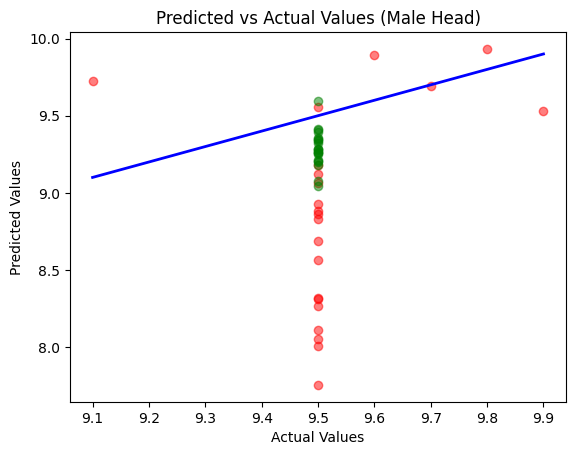

In [ ]:

def plot_difference(hfat_data, normal_data, df_predictions, Sex, Tissue):

    hfat_true = []
    hfat_pred = []

    normal_true = []
    normal_pred = []

    with torch.no_grad():
        loss = 0
        for i, (inputs, labels, indices) in enumerate(hfat_data):
            predictions = model(inputs)
            hfat_pred.extend(predictions.squeeze().numpy())
            hfat_true.extend(labels.squeeze().numpy())
            loss += F.mse_loss(predictions, labels)

            temp_df = pd.DataFrame({
                'index': [int(i) for i in indices.squeeze()],
                'Sex': [Sex] * len(indices),
                'Tissue': [Tissue] * len(indices),
                'Notes': ['HfatDiet'] * len(indices),
                'Age': labels.squeeze(),
                'Predicted_Age': predictions.squeeze()
            })
            if df_predictions.empty:
                df_predictions = temp_df
            else:
                df_predictions = pd.concat([df_predictions,temp_df], ignore_index=True)

        print (f'High Fat: MSE Loss: {loss / (i + 1):.5f} RMSE Loss: {math.sqrt(loss / (i + 1))}')

    with torch.no_grad():
        loss = 0
        for i, (inputs, labels, indices) in enumerate(normal_data):
            predictions = model(inputs)
            normal_pred.extend(predictions.squeeze().numpy())
            normal_true.extend(labels.squeeze().numpy())
            loss += F.mse_loss(predictions, labels)

            temp_df = pd.DataFrame({
                'index': [int(i) for i in indices.squeeze()],
                'Sex': [Sex] * len(indices),
                'Tissue': [Tissue] * len(indices),
                'Notes': ['Normal'] * len(indices),
                'Age': labels.squeeze(),
                'Predicted_Age': predictions.squeeze()
            })
            if df_predictions.empty:
                df_predictions = temp_df
            else:
                df_predictions = pd.concat([df_predictions,temp_df], ignore_index=True)

        print (f'High Fat: MSE Loss: {loss / (i + 1):.5f} RMSE Loss: {math.sqrt(loss / (i + 1))}')
        # print ('Normal:')
        # print(f'MSE Loss: {loss / (i + 1):.5f}')
        # print(f'RMSE Loss: {math.sqrt(loss / (i + 1))}')

    # Assuming `y_true` is the actual target values and `y_pred` is the predicted values
    plt.scatter(hfat_true, hfat_pred, c='red', alpha=0.5)
    plt.scatter(normal_true, normal_pred, c='green', alpha=0.5)
    plt.plot([min(normal_true + hfat_true), max(normal_true + hfat_true)], [min(normal_true + hfat_true), max(normal_true + hfat_true)], color='blue', lw=2)  # 45-degree line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs Actual Values ({Sex} {Tissue})')
    plt.show()

    return df_predictions





High Fat: MSE Loss: 0.75601 RMSE Loss: 0.8694869476575894
High Fat: MSE Loss: 0.14951 RMSE Loss: 0.3866658030012504


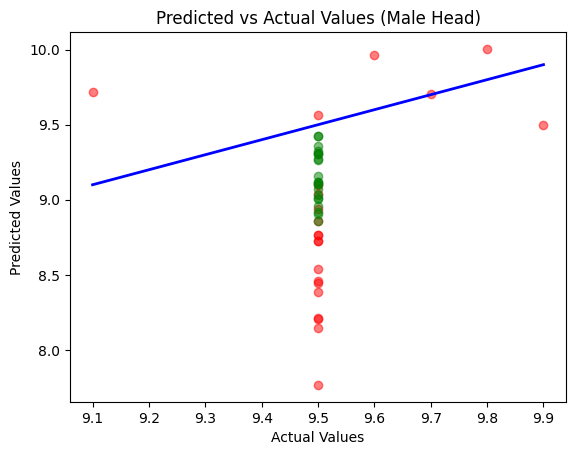

High Fat: MSE Loss: 1.23821 RMSE Loss: 1.1127470642236237
High Fat: MSE Loss: 0.12047 RMSE Loss: 0.3470941349713275


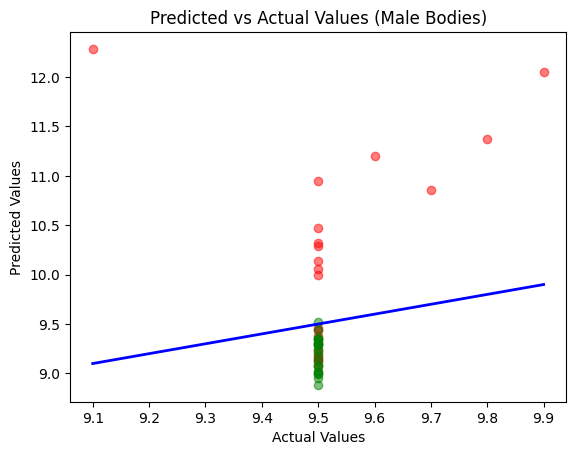

High Fat: MSE Loss: 0.06296 RMSE Loss: 0.25091396100245034
High Fat: MSE Loss: 0.11547 RMSE Loss: 0.3398061380729231


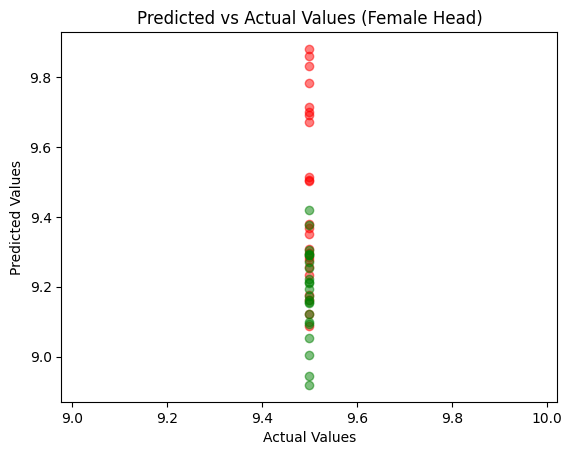

High Fat: MSE Loss: 0.36415 RMSE Loss: 0.6034480183582038
High Fat: MSE Loss: 0.26168 RMSE Loss: 0.5115515457593054


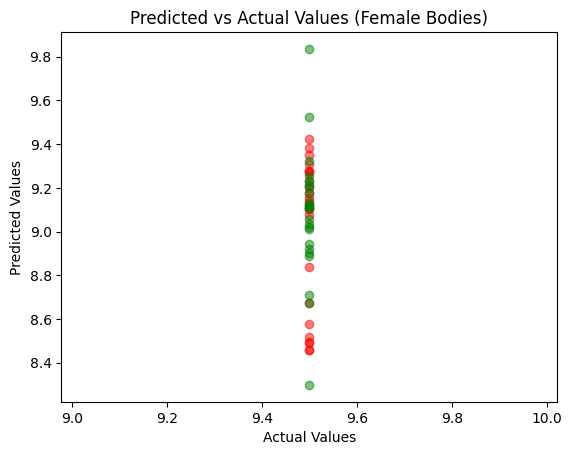

In [70]:
# test with valid data and plot
df_predictions = pd.DataFrame(columns=['index', 'Sex', 'Tissue' 'Notes', 'Age', 'Predicted_Age'])

df_predictions = plot_difference(MHF_valid_loader, MHN_valid_loader, df_predictions, 'Male', 'Head')
df_predictions = plot_difference(MBF_valid_loader, MBN_valid_loader, df_predictions, 'Male', 'Bodies')
df_predictions = plot_difference(FHF_valid_loader, FHN_valid_loader, df_predictions, 'Female', 'Head')
df_predictions = plot_difference(FBF_valid_loader, FBN_valid_loader, df_predictions, 'Female', 'Bodies')

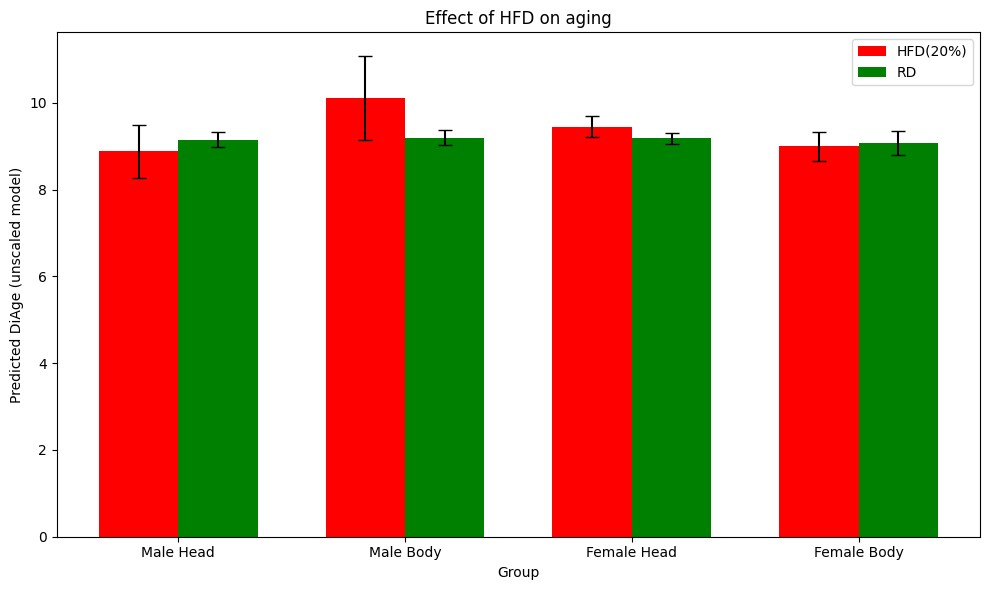

In [71]:
# Calculate means and standard deviations for each group
def filter_df(df, sex, tissue, diet):
    filtered_df = df[(df['Sex'] == sex) & (df['Tissue'] == tissue) & (df['Notes'] == diet)]
    return filtered_df['Predicted_Age'].tolist()
    
MHF_pred = filter_df(df_predictions, 'Male', 'Head', 'HfatDiet')
MHN_pred = filter_df(df_predictions, 'Male', 'Head', 'Normal')
MBF_pred = filter_df(df_predictions, 'Male', 'Bodies', 'HfatDiet')
MBN_pred = filter_df(df_predictions, 'Male', 'Bodies', 'Normal')

FHF_pred = filter_df(df_predictions, 'Female', 'Head', 'HfatDiet')
FHN_pred = filter_df(df_predictions, 'Female', 'Head', 'Normal')
FBF_pred = filter_df(df_predictions, 'Female', 'Bodies', 'HfatDiet')
FBN_pred = filter_df(df_predictions, 'Female', 'Bodies', 'Normal')

means = [
    np.mean(MHF_pred), np.mean(MHN_pred),
    np.mean(MBF_pred), np.mean(MBN_pred),
    np.mean(FHF_pred), np.mean(FHN_pred),
    np.mean(FBF_pred), np.mean(FBN_pred)
]
std_devs = [
    np.std(MHF_pred), np.std(MHN_pred),
    np.std(MBF_pred), np.std(MBN_pred),
    np.std(FHF_pred), np.std(FHN_pred),
    np.std(FBF_pred), np.std(FBN_pred)
]

# Bar labels and colors
groups = ['Male Head', 'Male Body', 'Female Head', 'Female Body']
colors = ['red', 'green']  # Red for HFD, Green for RD
labels = ['HFD(20%)', 'RD']

# Set positions and width for bars
x = np.arange(len(groups))
width = 0.35  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars with error bars for each group
rects1 = ax.bar(x - width/2, means[::2], width, label=labels[0], color=colors[0], yerr=std_devs[::2], capsize=5)
rects2 = ax.bar(x + width/2, means[1::2], width, label=labels[1], color=colors[1], yerr=std_devs[1::2], capsize=5)

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Group')
ax.set_ylabel('Predicted DiAge (unscaled model)')
ax.set_title('Effect of HFD on aging')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend()
#plt.ylim(0, 14)

# Adding significance annotations manually for illustration
# Customize these annotations as per your significance test results
# ax.text(x[0] - width / 2, means[0] + std_devs[0] + 0.5, '† (p=0.06)', ha='center')
# ax.text(x[1] - width / 2, means[2] + std_devs[2] + 0.5, '**', ha='center')
# ax.text(x[2] - width / 2, means[4] + std_devs[4] + 0.5, '***', ha='center')
# ax.text(x[3] - width / 2, means[6] + std_devs[6] + 0.5, 'n.s. (p=0.75)', ha='center')

# Show plot
plt.tight_layout()
plt.show()

In [72]:
df_predictions.to_csv(f'models/predictions/{model_file}.csv')
df_predictions

,index,Sex,Tissue,Notes,Age,Predicted_Age
0,22,Male,Head,HfatDiet,9.5,8.725067
1,23,Male,Head,HfatDiet,9.5,8.861279
2,24,Male,Head,HfatDiet,9.5,9.036250
3,25,Male,Head,HfatDiet,9.5,8.539056
4,26,Male,Head,HfatDiet,9.5,8.765508
...,...,...,...,...,...,...
177,154,Female,Bodies,Normal,9.5,9.013459
178,155,Female,Bodies,Normal,9.5,9.321938
179,156,Female,Bodies,Normal,9.5,9.253365
180,157,Female,Bodies,Normal,9.5,9.113276
